# Notebook #2: Analysis of the Design

In [1]:
import numpy as np
import pandas as pd
import definitive_screening_design as dsd
from definitive_screening_design.analysis import get_map_of_correlations, get_X, get_efficiency, get_variance

import pyDOE2 as pydoe # Need for: `pip install pydoe2`. This library is needed to compare DSD with conventional DOEs.

In [2]:
# Create a DSD with 5 numerical factors and convert it from the default pandas.DataFrame to a numpy.array
A = dsd.generate(5, 0).to_numpy()
A

Generating a Definitive Screening Design with 5 numerical and 0 categorical factors.


array([[ 0.,  1.,  1.,  1.,  1.],
       [ 0., -1., -1., -1., -1.],
       [ 1.,  0., -1.,  1.,  1.],
       [-1.,  0.,  1., -1., -1.],
       [ 1., -1.,  0., -1.,  1.],
       [-1.,  1.,  0.,  1., -1.],
       [ 1.,  1., -1.,  0., -1.],
       [-1., -1.,  1.,  0.,  1.],
       [ 1.,  1.,  1., -1.,  0.],
       [-1., -1., -1.,  1.,  0.],
       [ 1., -1.,  1.,  1., -1.],
       [-1.,  1., -1., -1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.]])

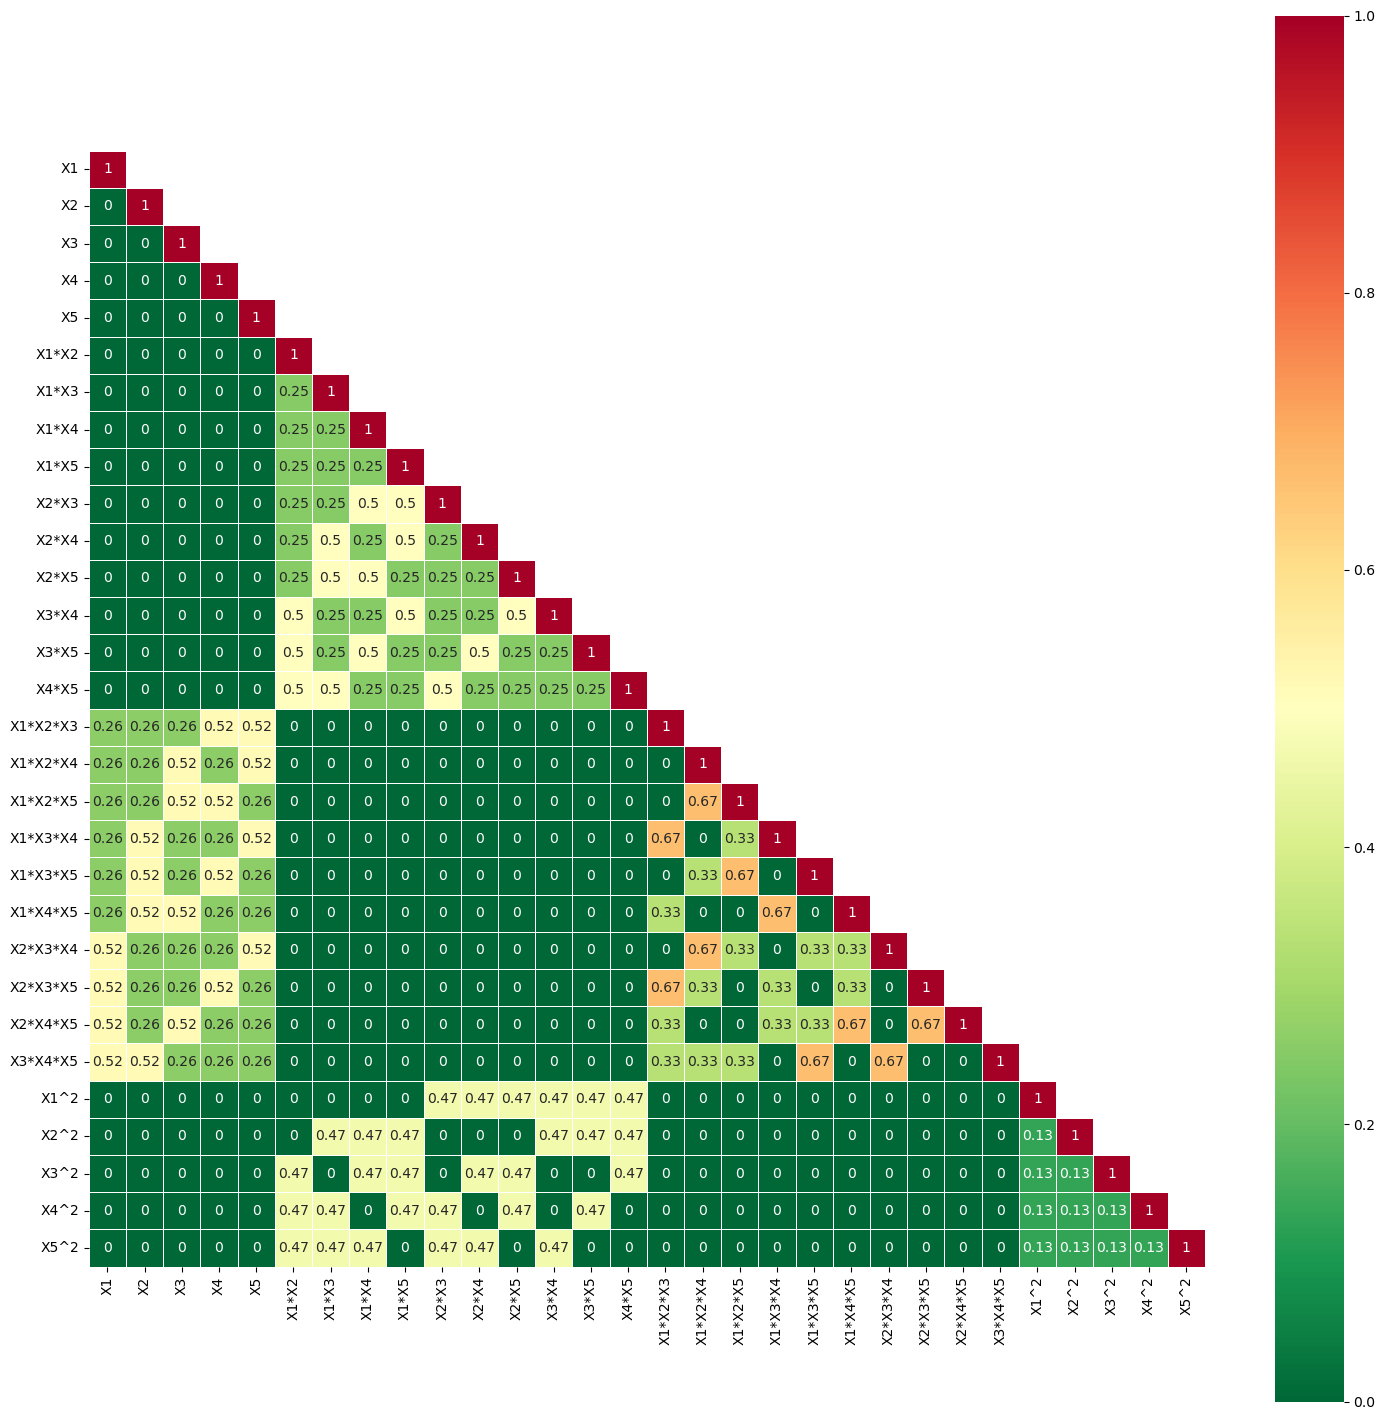

In [3]:
# Get the map of correlations considering a model will all effects 
moc = get_map_of_correlations(A, effects=["intercept", "main", "2-interactions", "3-interactions", "quadratic"], absolute=True, plot=True, figsize=[18,18])

In [4]:
# Get the DSD D-Efficiency with a simple {Intercept + Main Effects} model, which is the typical metric in softwares like JMP
X = get_X(A, effects=["intercept", "main"])
XTX = np.dot(X.T, X)
n_trials = X.shape[0]
n_params = X.shape[1]
D_Eff = 100* np.linalg.det(XTX)**(1/n_params)/n_trials # 
print(f"D-Efficiency: {D_Eff:.5f}% ({n_trials} trials, {n_params} parameters: intercept & main)")

D-Efficiency: 80.36135% (13 trials, 6 parameters: intercept & main)


## Comparison of DSD Efficiency and Effects' correlation with other DOEs
Considering different linear models built on the combinations of possible effects.

In [5]:
# Other DOEs
# NOTE: the range of the design space should be between -1 and +1 for all designs
Aff2 = pydoe.fullfact(levels=[2]*5)
Aff2 = np.select([Aff2==0], [-1], Aff2)
Aff3 = pydoe.fullfact(levels=[3]*5)-1
Apb = pydoe.pbdesign(5) # Plackett-Burman https://pythonhosted.org/pyDOE/factorial.html#plackett-burman
Abb = pydoe.bbdesign(5) # Box-Behnken https://pythonhosted.org/pyDOE/rsm.html#box-behnken
Acc = pydoe.ccdesign(5, center=(4,4), alpha="o", face="ccc")
Acc = Acc/Acc.max() # Need to keep the max value in [-1, 1] for comparison purpose
Alh = pydoe.lhs(5, samples=25, criterion="centermaximin", iterations=1000)
Af2c = np.vstack([Aff2, np.zeros([3, Aff2.shape[1]])])
AfrV = pydoe.fracfact("a b c d abcd")    # NOTE: in pyDOE2 you need to know and specify the aliased effects => https://github.com/statease/dexpy/blob/e79f2627a12e9be0c525a2096fe19b695850b1d3/dexpy/factorial.py#L42-L62
AfrIII = pydoe.fracfact("a b c d abcd")                                           
Ads1 = dsd.generate(5, 0, n_fake_factors=2, verbose=False).to_numpy() # 2 fake factors add 4 more trials
Ads2 = dsd.generate(5, 0, n_fake_factors=4, verbose=False).to_numpy() # 4 fake factors add 8 more trials

In [6]:
effects_tuple = (
    ["intercept", "main"],
    ["intercept", "main", "2-interactions"],
    ["intercept", "main", "quadratic"],
    ["intercept", "main", "2-interactions", "quadratic"],
    ["intercept", "main", "2-interactions", "3-interactions", "quadratic"],
)

does = {
    '2^k full-factorial  ': Aff2,
    '2^k ff w/center     ': Af2c,
    '2^(k-1) - V Resol.  ': AfrV,
    '2^(k-2) - III Resol.': AfrIII,
    '3^k full-factorial  ': Aff3,
    'Plackett-Burman     ': Apb,
    'Box-Behnken Surface ': Abb,
    'Central-composite   ': Acc,
    'Latin-Hypercube MxMn': Alh,
    'Definitive Screening': A,
    'Def. Screen. - Augm1': Ads1,
    'Def. Screen. - Augm2': Ads2,
}

2^k full-factorial  


/home/daniele/anaconda3/envs/base1/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/daniele/anaconda3/envs/base1/lib/python3.8/site-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


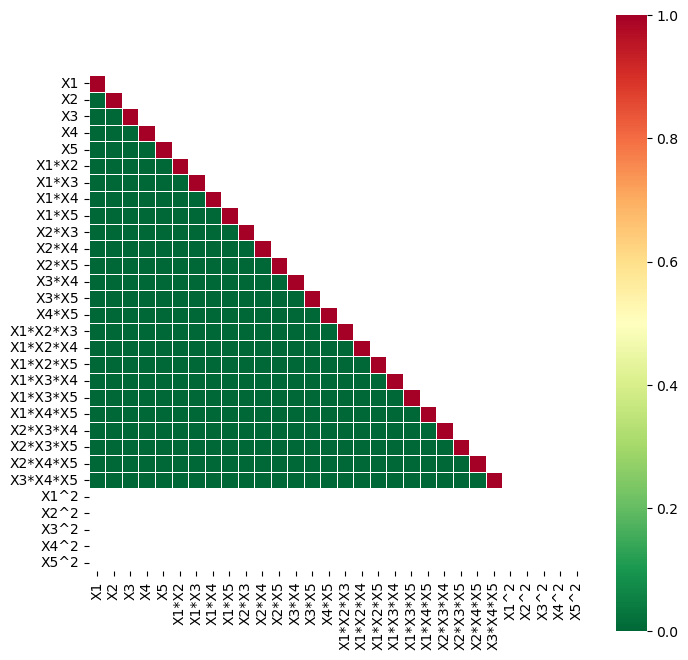

2^k ff w/center     


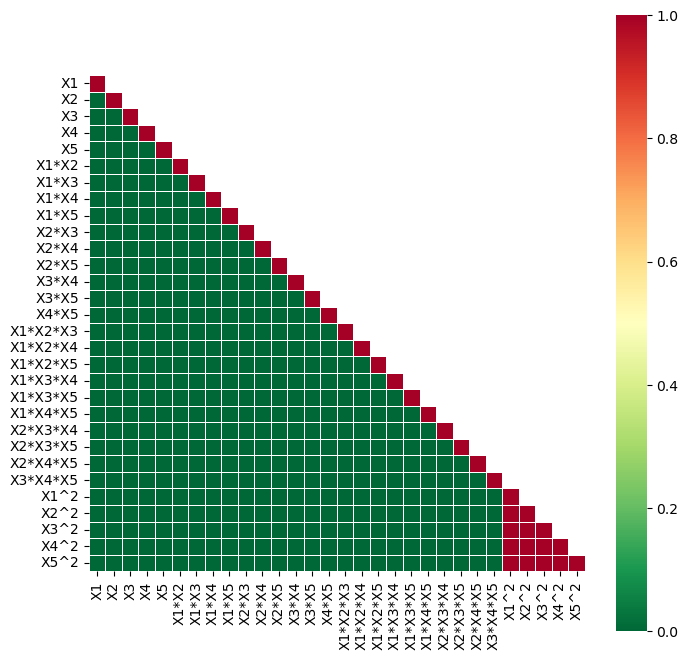

2^(k-1) - V Resol.  


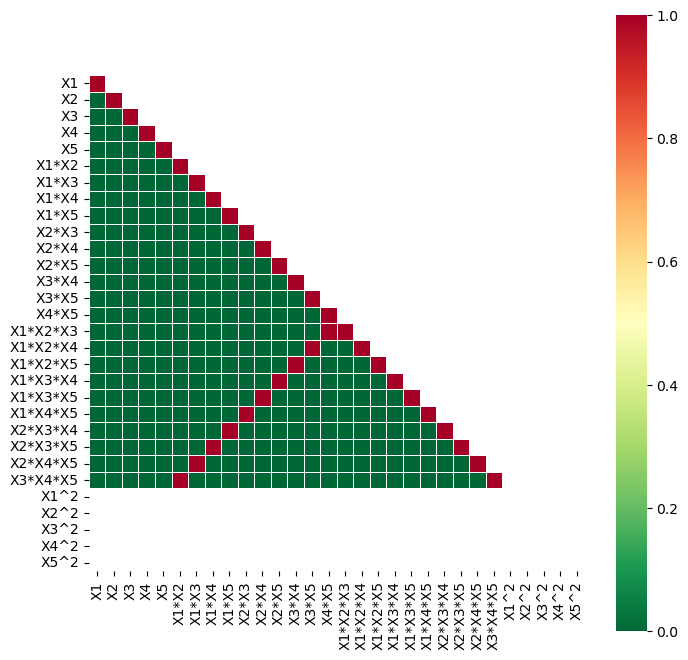

2^(k-2) - III Resol.


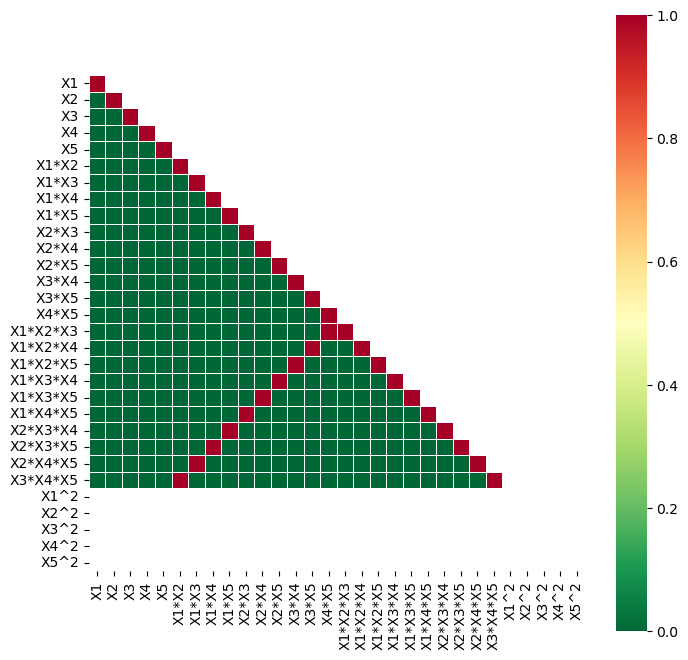

3^k full-factorial  


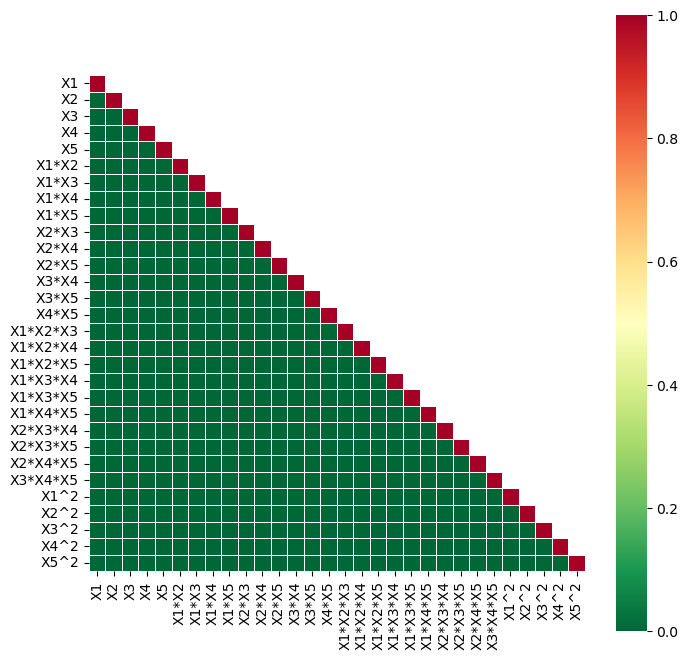

Plackett-Burman     


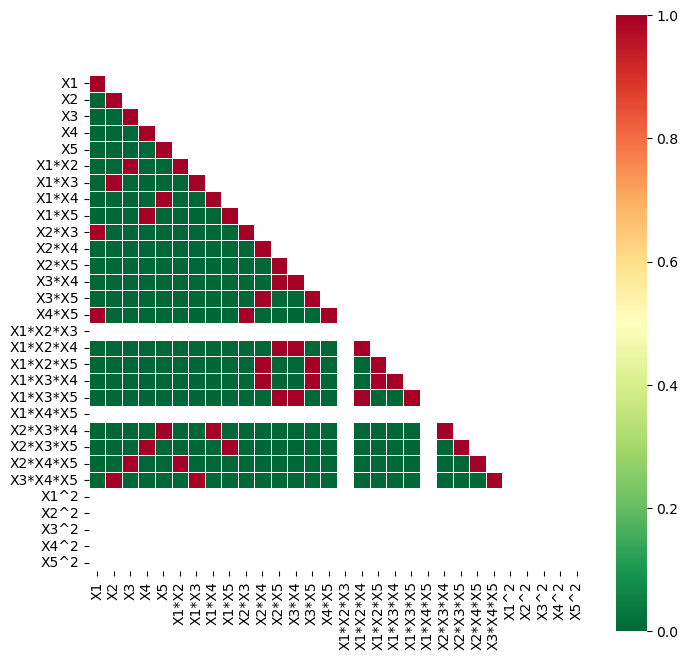

Box-Behnken Surface 


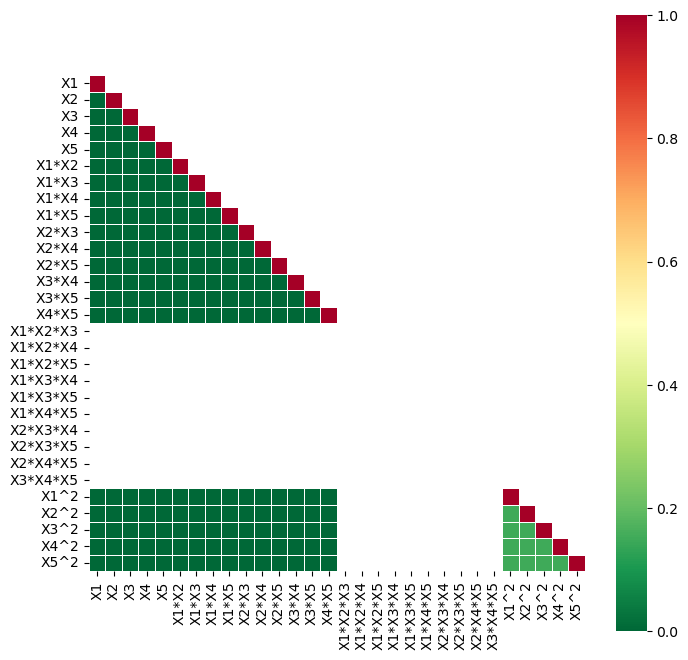

Central-composite   


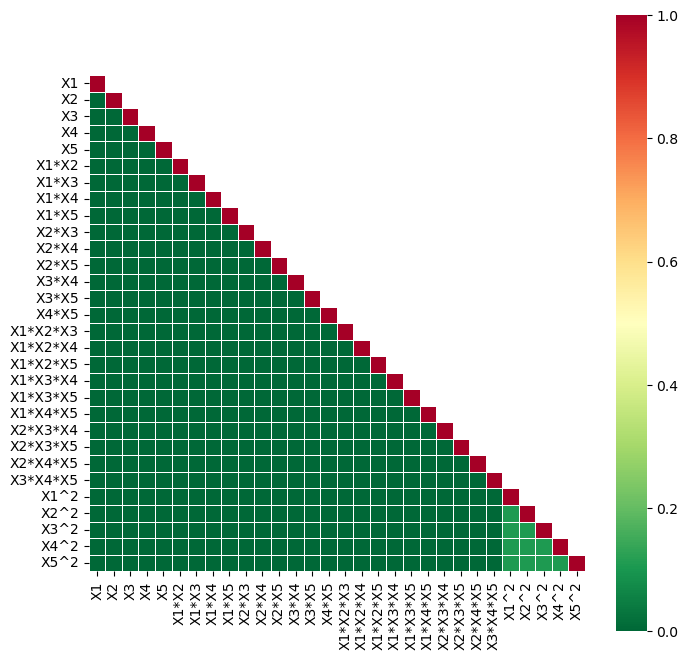

Latin-Hypercube MxMn


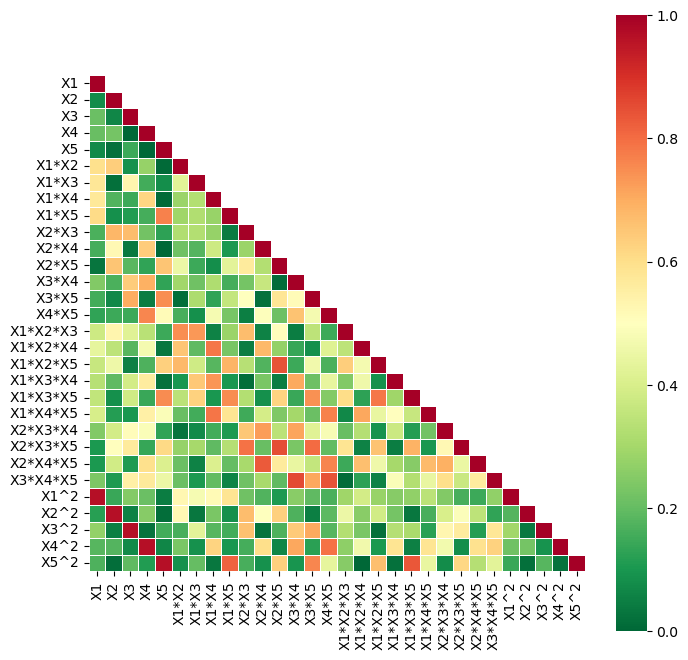

Definitive Screening


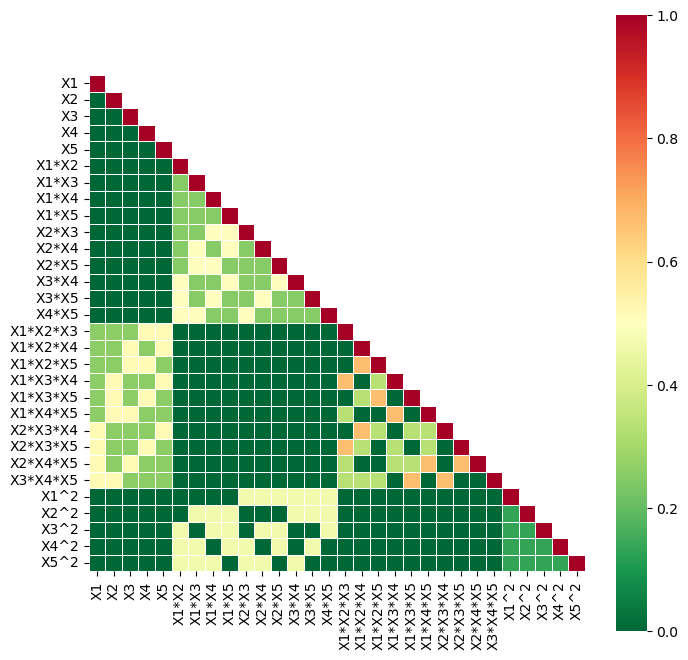

Def. Screen. - Augm1


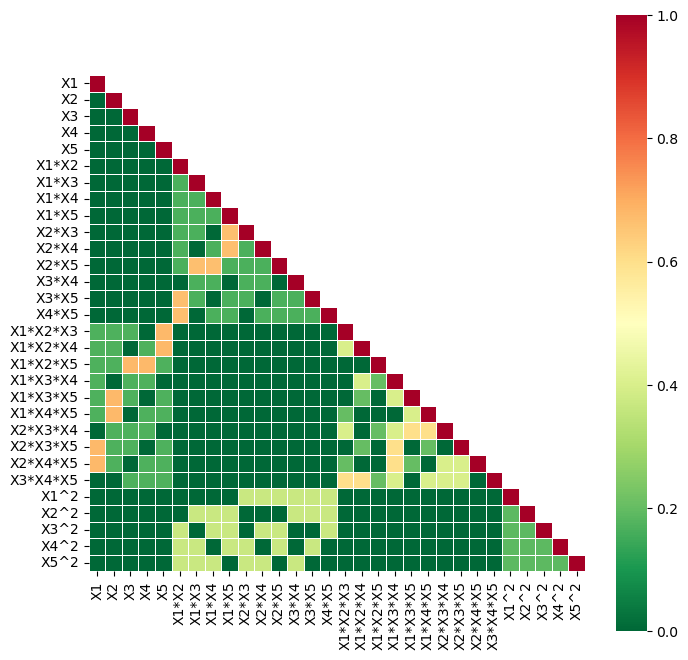

Def. Screen. - Augm2


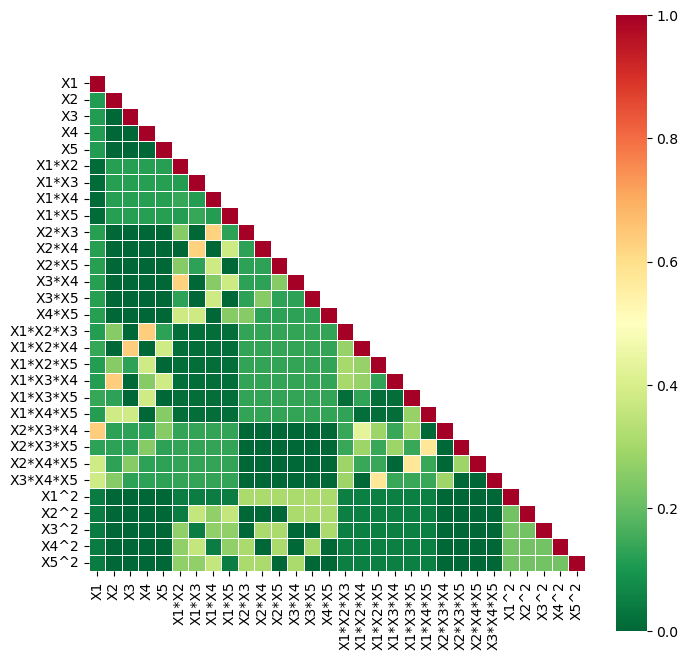

In [7]:
# Compute maps of correlations
for k, Ai in does.items():
    print(k)
    moc = get_map_of_correlations(Ai, effects=['intercept', 'main', '2-interactions', '3-interactions', 'quadratic'], absolute=True, 
            plot=True, annot=False, figsize=(8,8))

In [8]:
# Compute efficiencies
for effects in effects_tuple:
    print("Analysis for effects:", effects)
    for k, Ai in  does.items():
        n_trials, n_params, D_Eff, A_Eff = get_efficiency(Ai, effects).values()
        print(f" >> {k} ({n_trials:3d} trials, {n_params:2d} parameters)  ->  D-Eff.= {D_Eff:9.5f}%, A-Eff.= {A_Eff:9.5f}% ")
    print()

Analysis for effects: ['intercept', 'main']
 >> 2^k full-factorial   ( 32 trials,  6 parameters)  ->  D-Eff.= 100.00000%, A-Eff.= 100.00000% 
 >> 2^k ff w/center      ( 35 trials,  6 parameters)  ->  D-Eff.=  92.80434%, A-Eff.=  92.75362% 
 >> 2^(k-1) - V Resol.   ( 16 trials,  6 parameters)  ->  D-Eff.= 100.00000%, A-Eff.= 100.00000% 
 >> 2^(k-2) - III Resol. ( 16 trials,  6 parameters)  ->  D-Eff.= 100.00000%, A-Eff.= 100.00000% 
 >> 3^k full-factorial   (243 trials,  6 parameters)  ->  D-Eff.=  71.32755%, A-Eff.=  70.58824% 
 >> Plackett-Burman      (  8 trials,  6 parameters)  ->  D-Eff.= 100.00000%, A-Eff.= 100.00000% 
 >> Box-Behnken Surface  ( 46 trials,  6 parameters)  ->  D-Eff.=  41.47647%, A-Eff.=  39.02439% 
 >> Central-composite    ( 50 trials,  6 parameters)  ->  D-Eff.=  19.75839%, A-Eff.=  16.66667% 
 >> Latin-Hypercube MxMn ( 25 trials,  6 parameters)  ->  D-Eff.=  12.19554%, A-Eff.=   6.98123% 
 >> Definitive Screening ( 13 trials,  6 parameters)  ->  D-Eff.=  80.3613

/home/daniele/Dropbox/Programs/definitive_screening_design/definitive_screening_design/analysis.py:62: RuntimeWarning: invalid value encountered in double_scalars
  D_eff = 100 * np.linalg.det(XTX)**(1/n_params)/n_trials
